### Tejan Patel

# Analysis of Winning in the NBA

## Research Questions

1. Which 4 statistics in an NBA game have the greatest impact on winning? Hundreds of statistics are kept for every game, such as points, rebounds, assists, blocks, etc. but I want to find which of the basic stats are the most important when predicting a winner. 

The four statistics I found were field goals made, field goal percentage, field goals attempted, and defensive rebounds.

2. Do advanced statistics such as true shooting and effective position ratio better indicate winners than basic statistics such as points, rebounds, and assists? The presence of advanced stats in the NBA is consistently increasing and being used in decision-making. I want to see if this is justified.

Advanced stats in particular, true shooting percentage, effective field goal percentage, assist to turnover ratio and effective possession ratio, do not better indicate winners than basic statistics.

3. Although physical attributes don’t vary much for each team, can average age, weight or height impact winning? Which one is most important?

Relative to other statistics, the age, weight, and height of a team don’t have much of an influence on winning. However, out of the three, age was the most important factor.


## Motivation

From a young age, I was always obsessed with basketball. Playing and watching basketball was my favorite pastime and I fell in love with the game. Of course, winning is the objective and each coach I have ever had has given me different keys to winning a game. This goes to show how there isn’t a specific recipe to win. However, there is always an opportunity for competitive advantages. Understanding the game using high-level statistics may be able to give new insights into a strategy to maximize a team’s chances of winning. If we obtain verifiable answers to these research questions, coaching could be revolutionized.


## Data Setting

URL: https://www.basketball-reference.com/

This site contains information for every basketball season from the start of the NBA to present times. The site contains data for every season each team has played. Each team has a full table containing wins and other stats from each season in the NBA. Since there is not just one site that has put every team’s data, I will have to individually scrape for each team and merge the data to form my data set. Given that each team has been around for around 60 years and there are 30 teams, I should be able to get a decent sample. However, older seasons may not have all statistics calculated.


## Method

1. Utilize webscraping techniques in particular Beautiful Soup to create an accessible data set accomplishing challenge goal 1 
2. Clean data to create consistency depending on the length of the season by making total stats averages per game
3. Use RFE, SFS, and Correlation to find three combinations of the four most important stats
4. Develop a model for each combination of stats
5. Use Cross Validation score to determine which one is best (Research Question 1) (challenge goal 2)
6. Develop a model to assess how basic stats can predict a winner based on cross-validation from step 5
7. Develop a very similar model as step 6 but only analyze advanced stats
8. Compare the models in step 6 and 7 using iterations of train test and cross val score (Research Question 2) (challenge goal 2)
9. Develop a model using basic stats including height age and weight
10. Compare the model in steps 3 and 6 and assess the impact of including age weight and height (Research Question 3)
11. Develop a model for only physical stats and see which is weighted the heaviest
12. Draw conclusions to develop a strategy for winning


## Webscraping and Data Formatting

In [2]:
from bs4 import BeautifulSoup
import requests
import os
import pandas as pd
import numpy as np

In [2]:
nba_teams = [
    'ATL', 'BOS', 'BRK', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 
    'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 
    'OKC', 'ORL', 'PHI', 'PHO', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS'
]
dfs=[]

In [3]:
base_url='https://www.basketball-reference.com/teams/{nba_team}/stats_basic_totals.html'
for nba_team in nba_teams:
    url = base_url.format(nba_team=nba_team)
    page=requests.get(url)
    soup=BeautifulSoup(page.text,'html.parser')
    tables=soup.find_all('table')
    if (len(tables)>0):
        table=tables[0]
        dfs.append(pd.read_html(str(table))[0])

In [4]:
result_df = pd.concat(dfs, ignore_index=True)
result_df=result_df[result_df['Season']!='Season']
result_df=result_df.drop(['Unnamed: 6','Unnamed: 10'], axis=1)

##Save to CSV: I used so I didn't have to webscrape every time
#result_df.to_csv('team_stats.csv',index=False)

In [3]:
team_data=pd.read_csv('team_stats.csv')

In [4]:
team_data.head()

,Season,Lg,Tm,W,L,Finish,Age,Ht.,Wt.,G,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,2023-24,NBA,ATL,26,34,3,26.1,6-6,210.0,60,...,0.810,780.0,1924.0,2704.0,1568,446.0,274.0,801.0,1113,7226
1,2022-23,NBA,ATL,41,41,2,24.9,6-6,210.0,82,...,0.818,920.0,2719.0,3639.0,2049,580.0,401.0,1060.0,1541,9711
2,2021-22,NBA,ATL,43,39,2,26.1,6-6,211.0,82,...,0.812,823.0,2783.0,3606.0,2017,587.0,348.0,972.0,1534,9343
3,2020-21,NBA,ATL,41,31,1,25.4,6-6,214.0,72,...,0.812,760.0,2525.0,3285.0,1737,503.0,342.0,953.0,1392,8186
4,2019-20,NBA,ATL,20,47,5,24.1,6-6,216.0,67,...,0.790,661.0,2237.0,2898.0,1605,523.0,341.0,1086.0,1548,7488


## Adjust Data

In [5]:
team_data['W%']=team_data['W']/(team_data['W']+team_data['L'])
team_data['TS%']=team_data['PTS']/(2*(team_data['FGA']+0.44*team_data['FTA']))
team_data['Effective Possesion']=(team_data['PTS']+0.4*team_data['FT'])/(team_data['FGA']+.4*team_data['FTA']-team_data['TOV'])
team_data['EFG%']=(team_data['FG']+.5*team_data['3P'])/team_data['FGA']
team_data['ASTOV']=team_data['AST']/team_data['TOV']
columns_to_adjust=['FG', 'FGA', '3P', '3PA', '2P', '2PA', 'FT',
       'FTA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS']
for column in columns_to_adjust:
    team_data[column]=team_data[column]/team_data['G']
team_data=team_data.dropna()

## Results

### Question 1

From my research, I have concluded that the most important stats that impact winning are field goals made, field goals attempted, field goal percentage, and defensive rebounds. Using the data, I utilized recursive feature elimination on a Ridge model to find the four most important features within the data. The Ridge model is essentially a regularized linear regression model and produced the result of 3-pointers made, 3-pointers attempted, 3 point percentage, and steals as the most important stats. Next, I found the four statistics with the highest correlation to winning percentage which are field goal percentage, 2-point field goal percentage, defensive rebounds, and assists. Then, I used sequential feature selection to find another subset of statistics which were field goals made, field goal percentage, field goals attempted, and defensive rebounds. By training three different models on these specific statistics and calculating the mean cross-validation score, I concluded that the model including field goals made, field goal percentage, field goals attempted, and defensive rebounds was the most accurate and hence those are the four most important statistics 

From this result, to gauge a team's winning percentage for a season, it is most important to look at field goal statistics and defensive rebounds. This was somewhat expected as the number of scoring opportunities directly impacts how many points a team can score. Field goals made and attempted are both direct indicators of scoring opportunities while field goal percentage is the best indicator of efficiency in those opportunities. In addition, defensive rebounds correlate to a bad field goal percentage for the opponent. This all suggests that increasing scoring opportunities is the best way to put a team in a place to win. In practice, this can be seen in greater emphasis on offensive rebounding and limiting turnovers. By doing this, teams can increase opportunities enhancing their win percentage.


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut

Selection by RFE

In [7]:
X=team_data.drop(['Season','Lg','Tm','W','L','Finish','Age','Ht.','Wt.' ,'G','MP','W%', 'TS%','EFG%','Effective Possesion', 'ASTOV'], axis=1)
y=team_data['W%']
rfe = RFE(Ridge(), step=1, n_features_to_select=0.2, verbose=1)
rfe.fit(X, y)
rfe_features = X.columns[[r == 1 for r in rfe.ranking_]]
print("Features:", list(rfe_features))
reg = rfe.estimator_

Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Features: ['3P', '3PA', '3P%', 'STL']


Selection by correlation

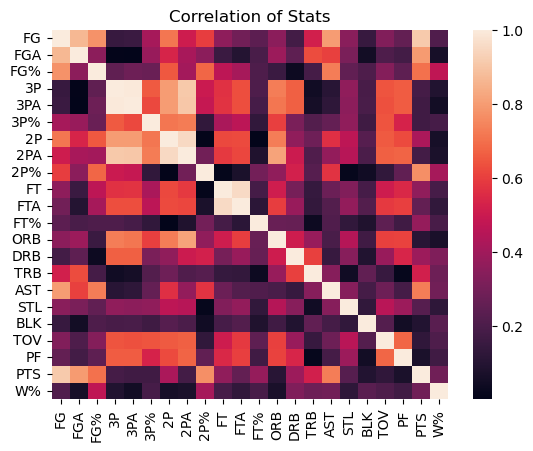

In [8]:
team_info=team_data.drop(['Season','Lg','Tm','W','L','Finish','Age','Ht.','Wt.' ,'G','MP', 'TS%','EFG%','Effective Possesion', 'ASTOV'], axis=1)
sns.heatmap(abs(team_info.corr()))
plt.title("Correlation of Stats")
plt.show()

In [9]:
features=abs(team_info.corr()["W%"][abs(team_info.corr()["W%"])>0.29].drop('W%')).index.tolist()
print("Features: ",features)

Features:  ['FG%', '2P%', 'DRB', 'AST']


Selection by SFS

In [10]:
X=team_data.drop(['Season','Lg','Tm','W','L','Finish','Age','Ht.','Wt.' ,'G','MP','W%', 'TS%','EFG%','Effective Possesion', 'ASTOV'], axis=1)
y=team_data['W%']
reg = Ridge()
sfs = SFS(reg, k_features=4, forward=True, scoring='neg_mean_squared_error', cv=5)
sfs.fit(X, y)
features_index = sfs.k_feature_idx_
features=[]
for i in features_index:
    features.append(X.columns[i])
print("Features: ",features)

Features:  ['FG', 'FGA', 'FG%', 'DRB']


##### Which selction of statistics is best? (Selecting by Cross Validation Score)

1st Option

In [13]:
X=team_data[['3P', '3PA', '3P%', 'STL']]
y=team_data['W%']
scores = cross_val_score(Ridge(), X, y, cv=5, scoring='neg_mean_squared_error')
mse_scores = abs(scores)
mean_mse = np.mean(mse_scores)
print ("Error: ", mean_mse)

Error:  0.018650474571272994


array([ 0.19629625, -0.07083759,  0.06190375,  0.03216112])

2nd Option

In [19]:
X=team_data[['FG%', '2P%', 'DRB', 'AST']]
y=team_data['W%']
scores = cross_val_score(Ridge(), X, y, cv=5, scoring='neg_mean_squared_error')
mse_scores = abs(scores)
mean_mse = np.mean(mse_scores)
print ("Error: ", mean_mse)

Error:  0.018773576398594356


3rd Option (Best Option)

In [17]:
X=team_data[['FG', 'FGA', 'FG%', 'DRB']]
y=team_data['W%']
scores = cross_val_score(Ridge(), X, y, cv=5, scoring='neg_mean_squared_error')
mse_scores = abs(scores)
mean_mse = np.mean(mse_scores)
print ("Error: ", mean_mse)
reg=Ridge().fit(X,y)
reg.coef_

Error:  0.013736415637902085


array([ 0.05155371, -0.03587399,  0.00069034,  0.02610184])

##### Testing on Solution

Leave One Out Cross Validation

In [16]:
X=team_data[['FG', 'FGA', 'FG%', 'DRB']]
y=team_data['W%']
reg=Ridge()
loo = LeaveOneOut()
predictions = []
true_values = []
mse_scores = cross_val_score(reg, X, y, scoring='neg_mean_squared_error', cv=loo)
mean_mse = np.mean(abs(mse_scores))
mean_mse

0.01358023120498836

Actual vs Predicted

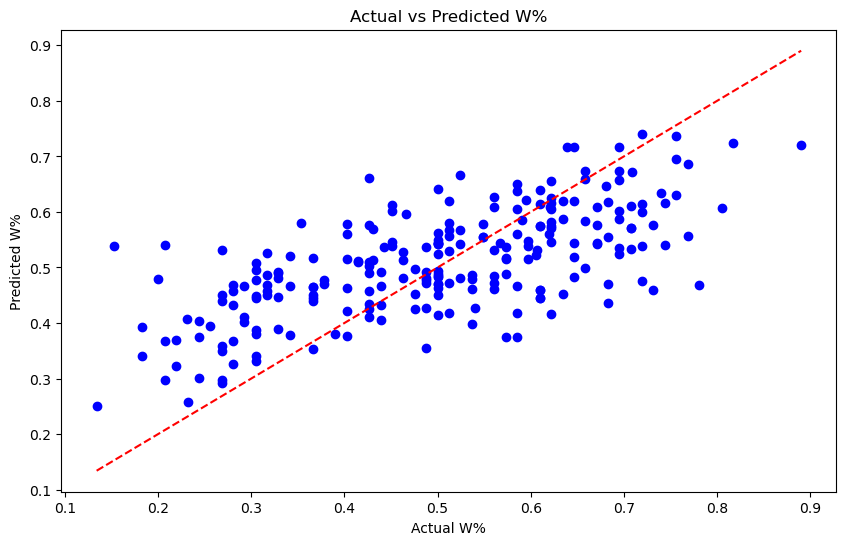

In [17]:
X=team_data[['FG', 'FGA', 'FG%', 'DRB']]
y=team_data['W%']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
reg=Ridge()
reg.fit(X_train,y_train)
y_pred=reg.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red')
plt.xlabel('Actual W%')
plt.ylabel('Predicted W%')
plt.title('Actual vs Predicted W%')
plt.show()

### Question 2

In researching this question, I have concluded that advanced stats are not better at predicting winning percentages. In comparing a regression model trained on advanced stats and a model trained on the most important basic stats from research question 1, the basic stats model performed better on both of my tests. In the first test, I used iterative testing by training a regression model 50 separate times using different train test splits and averaging out the error. In the second test, I used average cross-validation scores. Both tests yielded the same results that indicated that advanced stats are not better at predicting winning percentages. This surprised me because advanced stats take into account much more things than basic stats so I thought it would more accurately predict winning percentage. This could be due to the fact that advanced stats like true shooting percentage and effective field goal percentage give teams reprieve for bad shot selection. In judging how good a player shoots, this could be useful but in terms of predicting winning, it is not.

With this information, even in the era of advanced stats, NBA analysts should place less emphasis on them. It is more important to focus on basic stats that increase scoring opportunities and limit opponent’s opportunities since basic stats have proved more indicative of winning percentage. 


##### Iterative Testing Comparison

Basic Stats

In [18]:
X=team_data[['FG', 'FGA', 'FG%', 'DRB']]
y=team_data['W%']
error=0
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    reg= Ridge().fit(X_train,y_train)
    error+=mean_squared_error(y_test, reg.predict(X_test))
print("Average Error:", error/50)

Average Error: 0.01371287050992452


Advanced Stats

In [19]:
X=team_data[['TS%', 'Effective Possesion', 'EFG%', 'ASTOV']]
y=team_data['W%']
error=0
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    reg= Ridge().fit(X_train,y_train)
    error+=mean_squared_error(y_test, reg.predict(X_test))
print("Average Error:", error/50)

Average Error: 0.016132308693030933


##### Cross Validation Score

Basic Stats

In [20]:
X=team_data[['FG', 'FGA', 'FG%', 'DRB']]
y=team_data['W%']
scores = cross_val_score(Ridge(), X, y, cv=5, scoring='neg_mean_squared_error')
mse_scores = abs(scores)
mean_mse = np.mean(mse_scores)
print ("Error: ", mean_mse)

Error:  0.013736415637902085


Advanced Stats

In [21]:
X=team_data[['TS%', 'Effective Possesion', 'EFG%', 'ASTOV']]
y=team_data['W%']
scores = cross_val_score(Ridge(), X, y, cv=5, scoring='neg_mean_squared_error')
mse_scores = abs(scores)
mean_mse = np.mean(mse_scores)
print ("Error: ", mean_mse)

Error:  0.016494708372696867


##### Graph Comparison

Basic Stats

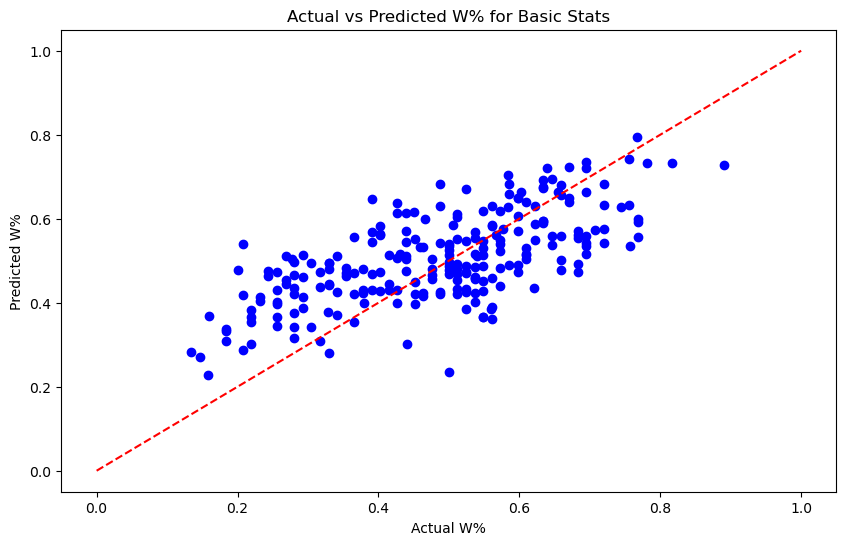

In [22]:
X=team_data[['FG', 'FGA', 'FG%', 'DRB']]
y=team_data['W%']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
reg=Ridge()
reg.fit(X_train,y_train)
y_pred=reg.predict(X_test)
plt.figure(figsize=(10, 6))
x=range(0,2)
plt.scatter(y_test, y_pred, color='blue')
plt.plot(x,x, linestyle='--', color='red')
plt.xlabel('Actual W%')
plt.ylabel('Predicted W%')
plt.title('Actual vs Predicted W% for Basic Stats')
plt.show()

Advanced Stats

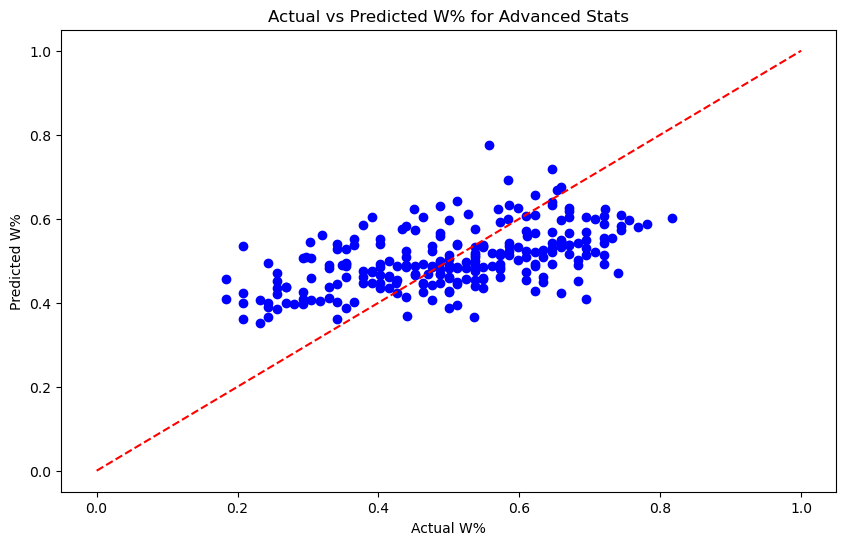

In [23]:
X=team_data[['TS%', 'Effective Possesion', 'EFG%', 'ASTOV']]
y=team_data['W%']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
reg=Ridge()
reg.fit(X_train,y_train)
y_pred=reg.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue')
x=range(0,2)
plt.plot(x,x, linestyle='--', color='red')
plt.xlabel('Actual W%')
plt.ylabel('Predicted W%')
plt.title('Actual vs Predicted W% for Advanced Stats')
plt.show()

### Question 3

My last conclusion is that age, height, and weight are not important factors in winning percentage. When training a model on a subset of statistics that included height, weight, and age, the weights placed on the three were relatively small. The model weighted the other statistics much higher. To further analyze this, I trained another regression model on height, age, and weight. In comparing the weights of each stat, age appeared to be the most important by far. However, since there was extremely low variation in each of these stats, it is hard to justify the importance of these measurements. It is better to focus on the playing statistics instead of the personnel stats.

In [21]:
team_data[['Ft', 'In']] = team_data['Ht.'].str.split('-', expand=True)
team_data['Ht In']=team_data['Ft'].astype(int)*12 + team_data['In'].astype(int)
team_data=team_data.drop(['Ft','In'], axis=1)

Weights with age, weight and height and error

In [25]:
X=team_data[['FG', 'FGA', 'FG%', 'DRB', 'Ht In', 'Wt.', 'Age']]
y=team_data[['W%']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
reg=Ridge(fit_intercept=False).fit(X_train,y_train)
error=mean_squared_error(y_test,reg.predict(X_test))
weights=reg.coef_[0]
age=weights[-1]
weight=weights[-2]
height=weights[-3]
print ('Age: ', age, ', Weight: ', weight, ', Height: ', height)
print('Error: ',error)
for i in reg.coef_[0]:
    print (i)

Age:  0.03190952087635183 , Weight:  -0.0010684311172365442 , Height:  -0.0016216397672003935
Error:  0.010628362003894214
0.04284675033239086
-0.0287845638148072
-0.028946495311823556
0.02514609813865173
-0.0016216397672003935
-0.0010684311172365442
0.03190952087635183


Error without

In [26]:
X=team_data[['FG', 'FGA', 'FG%', 'DRB']]
y=team_data[['W%']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
reg=LinearRegression(fit_intercept=False).fit(X_train,y_train)
error=mean_squared_error(y_test,reg.predict(X_test))
print ('Error: ',error)

Error:  0.013004538698092594


Which of age, weight and height are most important?

In [27]:
X=team_data[['Ht In', 'Wt.', 'Age']]
y=team_data[['W%']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
reg=LinearRegression(fit_intercept=False).fit(X_train,y_train)
error=mean_squared_error(y_test,reg.predict(X_test))
weights=reg.coef_[0]
age=weights[2]
weight=weights[1]
height=weights[0]
print ('Age: ', age, ', Weight: ', weight, ', Height: ', height)

Age:  0.046328206622447125 , Weight:  0.0001475193399528847 , Height:  -0.009802364358184386


## Impacts and Limitations

With the results that I concluded, coaches can adjust their strategy and NBA analysts can adjust their opinion on advanced statistics. In specific, coaches can adjust their game plans to fit the most important statistics I generated. From my results, coaches can gain some new perspective on what is really important when it comes to winning. As I said before, every coach has different views on what it takes to win, but my data gives an analytical baseline for strategy. In terms of advanced statistics, NBA analysts should not value them as heavily. Instead, advanced statistics should be valued equally to normal statistics as their impact on win percentage isn’t much different. 

Although NBA teams may benefit from my analysis, college basketball teams, high school basketball teams, and other organizations are left out. Each league is vastly different in terms of play style, so the conclusions I drew may not translate to every league. In addition, the time frame of the data set is very big as it is from 1970 to the present, but the NBA has changed tremendously in this time. The importance of certain statistics has most likely not stayed constant over the years. My analysis doesn’t take this into account because the data set would be very small if I grouped it by decades. Another limitation is the advanced statistics that were available. Since the website I scraped from didn’t have stats like offensive possessions, and rebounding percentages, I had to use more basic advanced statistics in my research. This definitely could’ve impacted my results and conclusions. Overall, although there is something to learn from the results I drew, it is important to take it with a grain of salt because the data isn’t perfect.


## Challenge Goals

##### New Library: 
I used BeautifulSoup to do the web scraping necessary to formulate my data set. The data was not in a csv so I used web scraping to create a data set. I had to scrape from a different website for each of the 30 teams and then concatenated the data frames to create the data set I used.

##### Result Validity: 
I extensively tested my different machine-learning models to verify my results. For research question 1, instead of using one method to find the most important statistics, I used three different strategies, RFE, correlation, and SFS. After I got the different combinations of statistics, I used cross-validation scores to determine which subset of stats was the most accurate. I also used another train test split on the model with the same parameters to confirm that it was the best pick. To further validate my result, I used a leave one out cross validation. Since the data set is relatively small for machine learning (about 1,200 entries), leave one out cross validation was a good way to ensure that all data is utilized. For research question 2, I used two testing methods to confirm my result. I used iterative testing first and then cross-validation. I chose iterative testing because it evaluated the models robustness. It is also helpful in seeing the models effectiveness in generalizing the data. In other words, it tests if the model is picking up consistent patterns within the data. This helped me gain confidence in the results I generated. Finally, the most basic result validation technique was graphing. I plotted actual vs expected to visualize the error in my models. Overall, to test my results, I used leave one out analysis, iterative testing, cross validation scores, and train test splits.


## Plan Evaluation

My work plan was very accurate. Since I was working alone, it was easy to split my work into segments and work progressively till the project was done. I estimated web scraping to be a week, analysis to be another week, and my final report to be the last week. This timeline was very accurate except for me taking a bit of extra time with the web scraping since I was unfamiliar with beautiful soup. Overall, working alone made me work efficiently and follow the timeline because I knew the amount of work I needed to complete.


## Testing

Since my code was mainly dependent on machine learning models, it was difficult to test. This is because every time I ran the code, a different error and output would be produced. This made it somewhat ineffective to use assert tests. This forced me to take other strategies to ensure the models were working as intended. My main strategy was to use my own understanding of the data and models to determine if the results were logical. I plugged logical numbers into the model and determined if the output was logical. Since it was predicting win percentage, I knew the output needed to be between around 0.25 at its lowest and 0.8 at its highest. You can tell my code computes as intended because the results are logical with the data set and have consistent results for machine learning models. Another strategy I used was using different testing features in Sci-Kit. I used train-test splits, cross validation scores, and leave one out cross validation to get error values for my models. If the errors were relatively similar across all tests, I knew my models were working correctly. Lastly, I plotted test splits against predictions beside the line y=x visualize the accuracy of predictions. One can tell the models are accurate because the data lies close to the target line.

## Collaboration

Although I didn’t consult any people for my project, I did rely on the Internet a lot. I used YouTube tutorials to learn how to web scrape. This was extremely helpful and vital to the success of my project. I also used package documentation very frequently, especially within Sci-Kit. Since I experimented a lot with feature selection and different regressors, it was important for me to understand all their different features and how they worked. Lastly, I used generative AI to generate ideas on how to answer my research questions. For instance, on question 1, I prompted ChatGPT to give me feature selection strategies. I didn’t have AI write any code for me.
